# Setup

In [21]:
from __future__ import division, print_function, unicode_literals
import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12

# Mnist

In [22]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [23]:
X, y =mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [24]:
y.shape

(70000,)

In [25]:
28*28

784

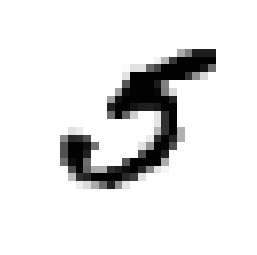

In [26]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary)

plt.axis("off")
plt.show()

In [27]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary)
    plt.axis()

In [28]:
# EXTRA
def plot_digits(instances, images_per_row):
    size = 28
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances)) // images_per_row
    row_images = []
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary)
    plt.axis("off")

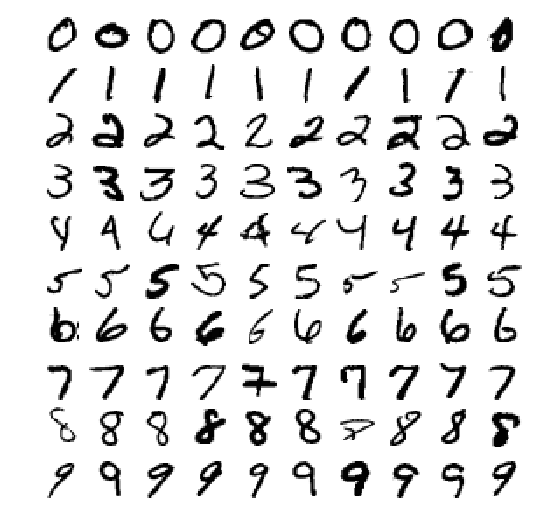

In [29]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, 10)
plt.show()

MNIST dataset is actually already split into a training set () the first 60000
and a test set (the last 10000 images)

In [95]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [31]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Binary classifier
Distinguishing between just classes, 5 and not-5

In [32]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [33]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [34]:
sgd_clf.predict([some_digit])

array([False], dtype=bool)

In [35]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.9651 ,  0.961  ,  0.96435])

do not get too excited even if you classify every single images not-5,
you will get 90% of accuracy. The better way is to llok at the confusion matrix. The general
idea is to count the number of times instances of class A are classified as classB

In [36]:
#just like the crpss_val_score function, cross_val_score performs
#k_fold cross validation, but instead of returning the evaluation score,
#it outputs the predictions made on each test hold.
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [37]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53609,   970],
       [ 1630,  3791]])

the first row of this matrix considers non 5 images (the negative class)
53426 of them were correctly classified as non 5 (true negative)
1153 were wrongly classified as 5 (false positive)
the second row considers 5 (the positive class)
1824 were wrongly classified as non 5 (false negative)
3597 were correctly classified as 5 (true positive)

In [38]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.79626128964503251

In [39]:
3597 / (1153 + 3597)

0.7572631578947369

In [40]:
recall_score(y_train_5, y_train_pred)

0.69931746910164172

In [41]:
3597 / (1824 + 3597)

0.6635307138904262

combine precision and recall into a single metric called F1
the F1 score is the hermonic mean of precision of recall. Whereas the
regular mean treats all values equally , the hermonic mean gives much more weights to low values.
As a result, the classifier will only get a high score if both recall and precision
score is high.

In [42]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.74464741701041037

In [43]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-60405.84686182])

In [44]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False], dtype=bool)

In [45]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False], dtype=bool)

how we decide which threshold to use?

In [46]:
#lets first caluculate the score of all the instances
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method="decision_function")

In [47]:
y_scores

array([ -480090.93625655, -2243919.46276659,  -673333.88771402, ...,
       -1122266.88851565,  -732606.39269228,  -414602.17376584])

Now with theses scores, you can compute precisom and recall for all possible
thresholds using the precision_recall_curve function

In [48]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

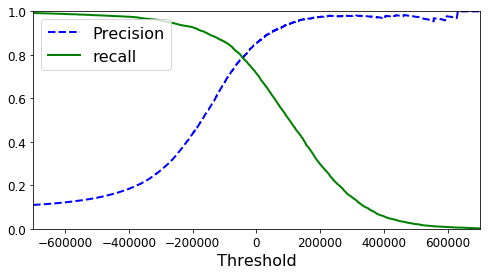

In [49]:
def plot_precision_recall_vs_threshold(precisions, recalls, threshold):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
plt.figure(figsize=(8,4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.ylim([0,1])
plt.xlim([-700000, 700000])
plt.show()

If you want to have 90% of precision. Based on the graph, you will use
70000 for threshold. To make predictions, you will

In [50]:
y_train_pred_90 = (y_scores > 70000)

In [51]:
precision_score(y_train_5, y_train_pred_90)

0.9219076005961252

In [52]:
recall_score(y_train_5, y_train_pred_90)

0.57055893746541231

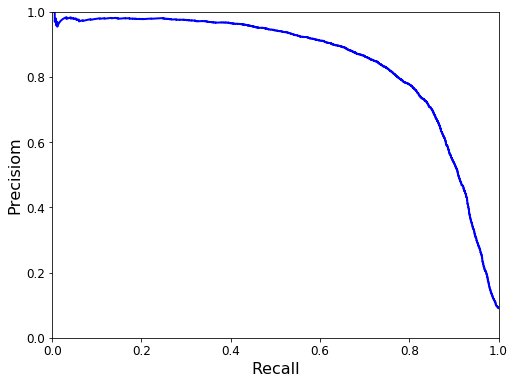

In [53]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)

plt.figure(figsize=(8, 6))
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precisiom", fontsize=16)
plt.axis([0, 1, 0, 1])
plot_precision_vs_recall(precisions, recalls)
plt.show()

# ROC curves
Receiver operating characteristic (ROC) curve is another common tool
used with binary classifiers. It is very similar to the precision/recall
curve. The ROC curves plots the true positive rate against the false positive rate

In [54]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

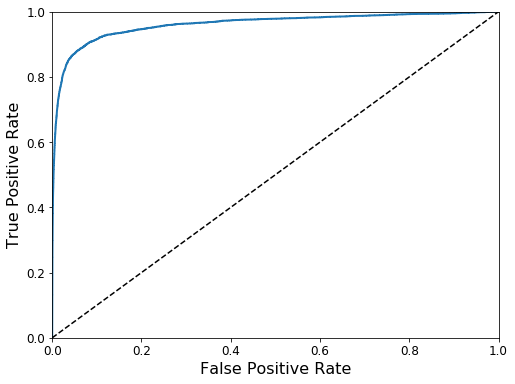

In [55]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0,1], [0, 1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
plt.figure(figsize=(8,6))
plot_roc_curve(fpr, tpr)

plt.show()

In [56]:
#area under the curve
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9608402137487756

In [57]:
#let's compare SGDClassifier and RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier()
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [58]:
y_scores_forest = y_probas_forest[:, 1] # probas of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

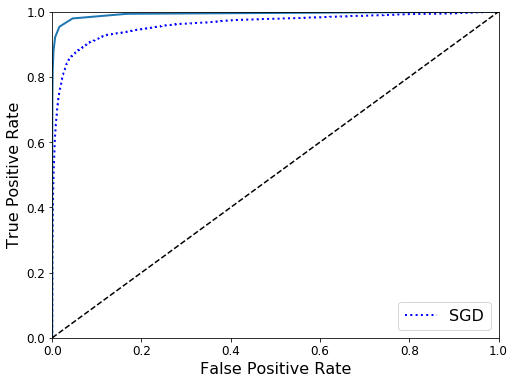

In [73]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [74]:
roc_auc_score(y_train_5, y_scores_forest)

0.99299647927371382

In [75]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.98131457463178717

In [76]:
recall_score(y_train_5, y_train_pred_forest)

0.82346430547869398

# Multiclass classification

In [77]:
#sckit learn detects when you try to use binary classification algorithms for
#multiclass classification and it automatically runs OvA
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([ 5.])

In [78]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -21397.63558601, -496792.82892596, -377683.04982637,
        -171319.23830204, -426032.0880312 ,  138177.47162926,
        -711090.42467494, -185591.06847851, -551121.19530864,
        -707249.29217005]])

In [79]:
np.argmax(some_digit_scores)

5

In [80]:
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

If you want to force sckit learn to use one versus one or one versus all
you can do so by

In [81]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier())
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([ 5.])

In [82]:
len(ovo_clf.estimators_)

45

For, RandomForest, SckitLearn does not have to run OvA or OvO because
Random Forest classifiers can directly classify intances into multiple classes

In [83]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 5.])

In [84]:
forest_clf.predict_proba([some_digit])

array([[ 0. ,  0. ,  0.1,  0. ,  0. ,  0.9,  0. ,  0. ,  0. ,  0. ]])

In [85]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.86017796,  0.85434272,  0.87163074])

This not too bad! But you can still do better! For example, simply 
simply scalig the inputs improve accuracy by 10%

In [86]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.91171766,  0.9099955 ,  0.90613592])

In [87]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5731,    4,   19,   10,   11,   49,   48,    9,   37,    5],
       [   2, 6495,   38,   25,    6,   39,    7,    9,  110,   11],
       [  52,   48, 5318,   91,   95,   24,   90,   59,  162,   19],
       [  51,   40,  139, 5344,    3,  242,   36,   57,  128,   91],
       [  15,   30,   37,   10, 5375,    7,   50,   35,   81,  202],
       [  67,   48,   30,  181,   70, 4621,  106,   31,  177,   90],
       [  37,   31,   42,    2,   49,   95, 5612,    5,   44,    1],
       [  27,   21,   67,   27,   56,   12,    4, 5798,   15,  238],
       [  55,  176,   66,  154,   14,  170,   56,   25, 4996,  139],
       [  41,   37,   28,   88,  176,   34,    2,  202,   75, 5266]])

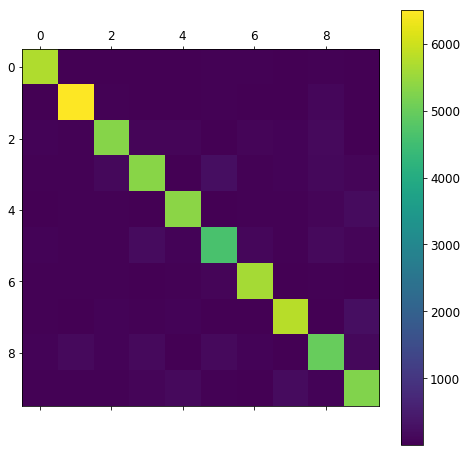

In [88]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)
plot_confusion_matrix(conf_mx)

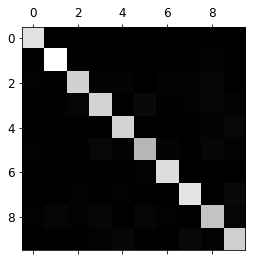

In [89]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Let's focus on the errors.

In [90]:
#first you need to divide each valie in the confusion matrix by the 
#number of images in the corresponding class. So you can compare error rates
#instead of absolute number of errors
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

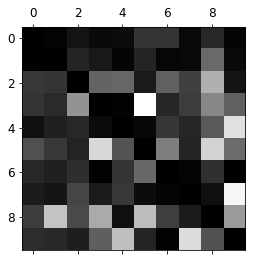

In [91]:
#lets fill out diagonal with 0 so you can focus on errors
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

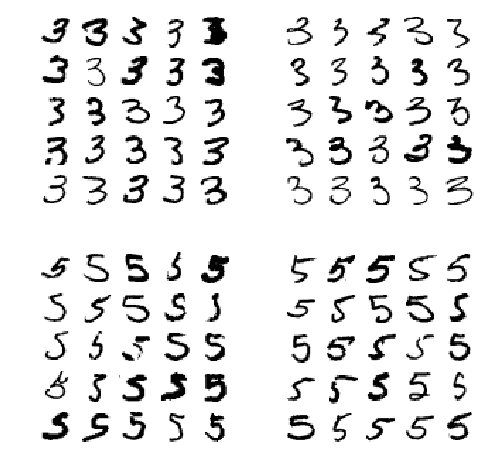

In [304]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], 5)
plt.subplot(222); plot_digits(X_ab[:25], 5)
plt.subplot(223); plot_digits(X_ba[:25], 5)
plt.subplot(224); plot_digits(X_bb[:25], 5)
plt.show()

# Multilabel classification

In [101]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [308]:
knn_clf.predict([some_digit])

array([[False,  True]], dtype=bool)

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

# Multioutput classification

In [97]:
noise = np.random.randint(0, 100, X_train.shape)
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, X_test.shape)
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

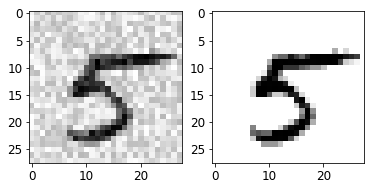

In [98]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

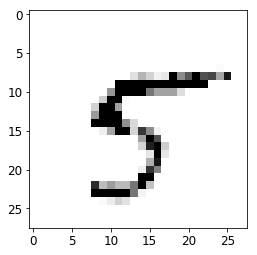

In [105]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
plt.show()